---
## Загрузка библиотек и модулей

---

In [1]:
using SciMLBase
using OrdinaryDiffEq
using ForwardDiff: jacobian

using DiffEqCallbacks

using StaticArrays
using LinearAlgebra
using Statistics

using Optim

using PyPlot

In [2]:
abstract type ODEType end

In [70]:
include("Utils\\CallBack_Utils.jl")
include("Utils\\Computation_Utils.jl")
include("ODEs\\BS_ODE.jl")
include("Utils\\Visualization_Utils.jl")
include("Utils\\Period_Utils.jl")

plotNorms (generic function with 1 method)

---

## Объединенная система (6 ДУ)

---

In [4]:
ODE_Parameters = Dict("K" => 1.5789473684210527,
                         "r" => 0.39473684210526316,
                         "a2" => pi/2,
                         "a4" => 3.24685581148453,
                         "Eps" => 1e-3)

Couple_function = Exp_Couple

Duo = BS_ODE_Duo(ODE_Parameters, Exp_Couple);

In [9]:
time_span = 1000.0
trans_time = 100.0

val = 0.1
ic = [0.0, pi, pi, 0.0, pi, pi]

ic = SVector{6}(ic .+ [r/10 for r in randn(6)])

alg = DP8()
callback(u, t, integrator) = cos(u[1])
kwargs = Dict(:dtmax => 1e-1, :dtmin => 1e-10, :abstol => 1e-13, :reltol => 1e-13, :maxiters => 1e10);

### Ode solving

In [11]:
@time trj = SolveODE(Duo, ic, time_span; alg, callback, trans_time, kwargs)
sol = trj.solution; trj

  0.981339 seconds (11.69 M allocations: 601.112 MiB, 24.73% gc time)


[ODE::BS_ODE_Duo]: [Forward_ODE::BS_ODE_Sngl]:
[K::Float64]: 1.5789473684210527
[r::Float64]: 0.39473684210526316
[a2::Float64]: 1.5707963267948966
[a4::Float64]: 3.24685581148453
[P::SVector{3, Float64}]: [-1.5702078118098561, -1.5789473684210527, -1.2246467991473532e-16]

[Backward_ODE::BS_ODE_Sngl]:
[K::Float64]: -1.5789473684210527
[r::Float64]: 0.39473684210526316
[a2::Float64]: 1.5707963267948966
[a4::Float64]: 3.24685581148453
[P::SVector{3, Float64}]: [1.5702078118098561, -1.5789473684210527, -1.2246467991473532e-16]

[Eps::Float64]: 0.001
[Couple::typeof(Exp_Couple)]: [Exp_Couple]: 1.0 / (1.0 + exp(10.0 * cos(x)))

[solution::py_sol{BS_ODE_Duo}]: [t]: 12770-element Vector{Float64}
[y]: 6-element Vector{Vector{Float64}} with size 12770
[t_events]: 1-element Vector{Vector{Float64}} with size 51
[y_events]: 1-element Vector{Matrix{Float64}} with size 51x6
[retcode]: Success

[alg::DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}]

In [12]:
s = RefinePeriod(trj, getPeriodTime(sol))
period = s.minimizer[1]; println("Trajectory period: $period with tolerance $(s.minimum)")
syncs = GetSyncs(sol); println(syncs)

Trajectory period: 39.51414381090338 with tolerance 2.235392724957936e-8
Synchronization: ["phi_1 => psi_2", "phi_2 => psi_1", "phi_3 => psi_3"] with delay: π



### Временные диаграммы

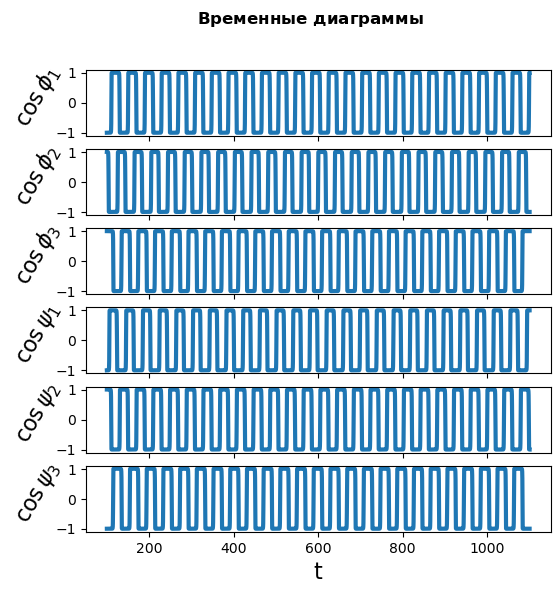

In [21]:
TimeSeries(;projFunc = "projCos", varNames = ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\psi_3"], plotKwargs = Dict(:linewidth => 3))(sol);

### Проекции траекторий и отображения Пуанкаре

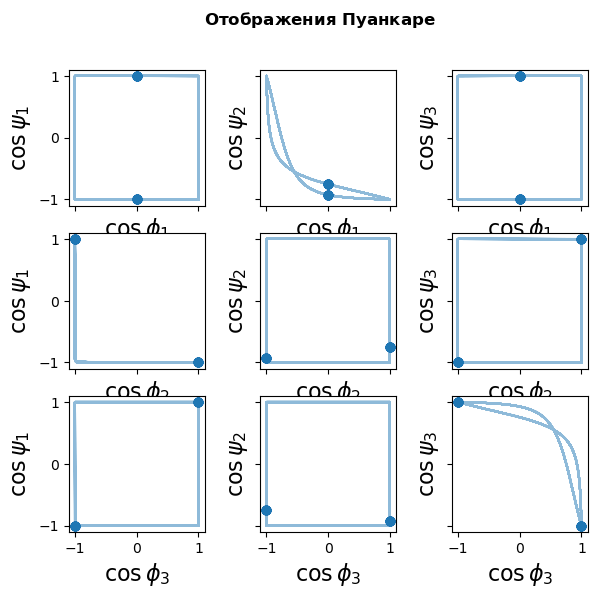

In [26]:
varPairs = [[[0, 3], [0, 4], [0, 5]],
            [[1, 3], [1, 4], [1, 5]],
            [[2, 3], [2, 4], [2, 5]]]

Poincare(; varPairs = varPairs, showEvents = true, plotKwargs = Dict(:linewidth => 1), projFunc = "projCos", varNames = ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\psi_3"])(sol);

### Времена возврата на секущую Пуанкаре

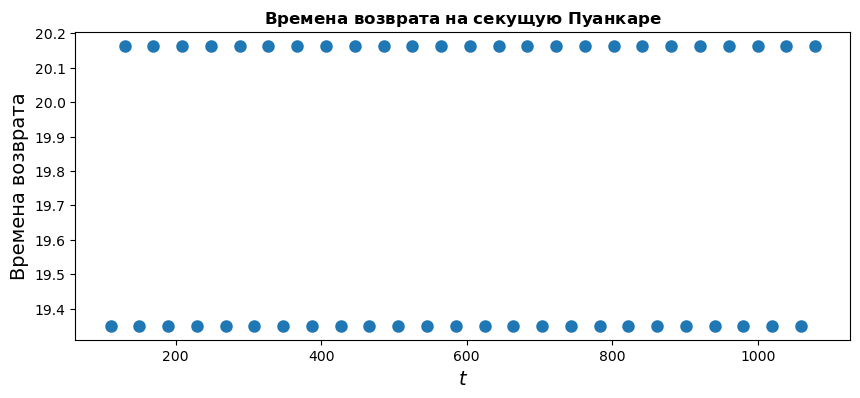

In [29]:
ReturnTime(normFunc = "normNone", plotKwargs = Dict(:linewidth => 3))(sol);

### Диаграмма активации элементов

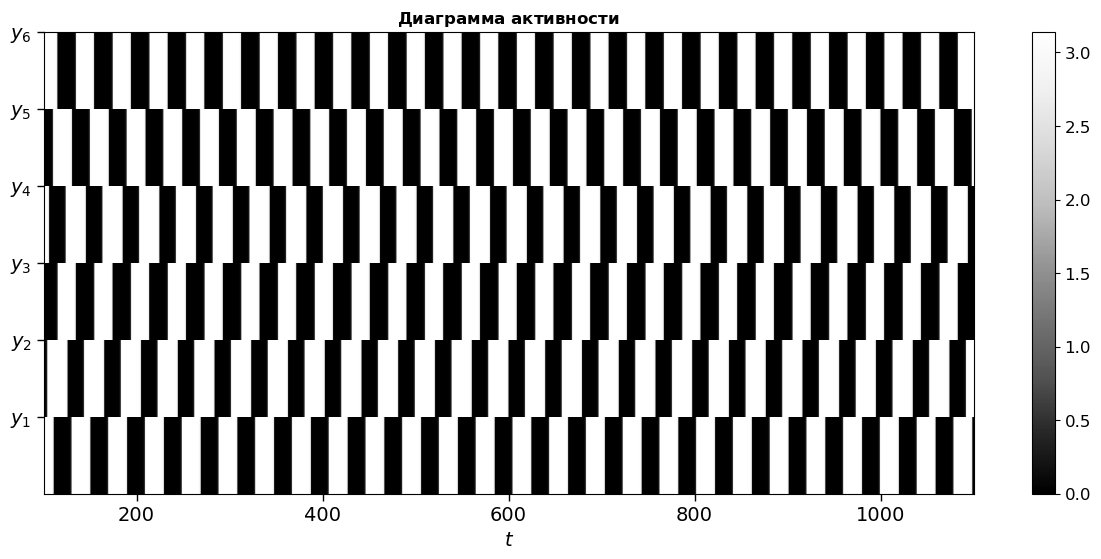

In [31]:
ActivationDiagram(continuous = true)(sol);

---

## Интегрирование полной системы совместно с системой в вариациях (6 + 6х6 ДУ)

---

In [35]:
Tan_Red = TangentODE(Duo, 6)

u0 = [y[1] for y in sol.y[1:3]]
Q0 = vec(diagm(ones(6)))

tanred_ic = cat(u0, Q0, dims = 1);

In [74]:
tan_trj = SolveODE(Tan_Red, tanred_ic, period; alg, kwargs)
ode_sol, tan_sol = splitSol(tan_trj.solution); tan_trj

[ODE::TangentODE]: [ODE::BS_ODE_Duo]: [Forward_ODE::BS_ODE_Sngl]:
[K::Float64]: 1.5789473684210527
[r::Float64]: 0.39473684210526316
[a2::Float64]: 1.5707963267948966
[a4::Float64]: 3.24685581148453
[P::SVector{3, Float64}]: [-1.5702078118098561, -1.5789473684210527, -1.2246467991473532e-16]

[Backward_ODE::BS_ODE_Sngl]:
[K::Float64]: -1.5789473684210527
[r::Float64]: 0.39473684210526316
[a2::Float64]: 1.5707963267948966
[a4::Float64]: 3.24685581148453
[P::SVector{3, Float64}]: [1.5702078118098561, -1.5789473684210527, -1.2246467991473532e-16]

[Eps::Float64]: 0.001
[Couple::typeof(Exp_Couple)]: [Exp_Couple]: 1.0 / (1.0 + exp(10.0 * cos(x)))

[Jacobian::var"#224#226"{BS_ODE_Duo}]: #224
[ODEDim::Int64]: 6
[JacDim::Int64]: 6

[solution::py_sol{TangentODE}]: [t]: 1254-element Vector{Float64}
[y]: 42-element Vector{Vector{Float64}} with size 1254
[t_events]: 1-element Vector{Vector{Float64}} with size 0
[y_events]: 1-element Vector{Matrix{Float64}} with size 0x0
[retcode]: Success

[alg::D

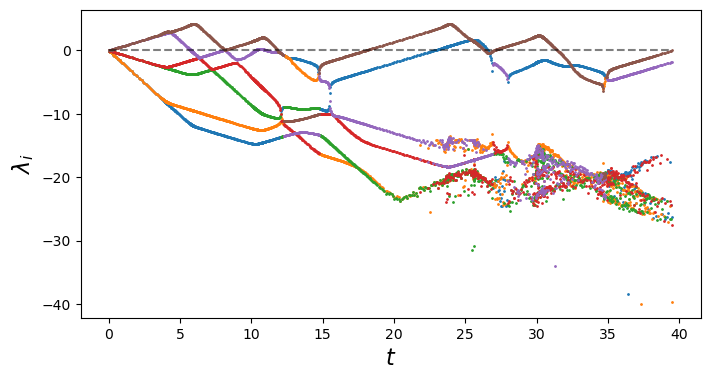

In [76]:
Eigens(projFunc = x -> log10(abs(x)))(tan_sol);

In [77]:
eigs = getTanEigens(tan_sol); [e[end] for e in eigs]

6-element Vector{Float64}:
 -5.806884709914609e-27
 -1.7679511690598842e-40
  0.0
  3.1983681181595783e-28
  0.016594824602048655
  1.000165976120357